# Unsupervised learning, multi-dimensional scaling and clustering

## Examples from currencies

### Get the data in
Let's start by getting the data on the FX trackers in the notebook:

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
fx_trackers = pd.read_csv('fx_trackers.csv',index_col=0)
fx_trackers.index = pd.to_datetime(fx_trackers.index)
fx_trackers.head()

,NOK,GBP,AUD,TWD,NZD,HUF,BRL,ZAR,PHP,IDR,...,INR,CNH,SEK,JPY,CZK,SGD,KRW,EUR,TRY,MXN
2004-04-23,105.77,124.25,111.59,96.44,119.55,157.02,113.82,130.02,132.55,315.00,...,133.99,NaN,97.87,61.96,132.37,96.48,110.45,136.56,290.29,124.14
2004-04-26,105.81,125.64,111.88,96.51,120.19,157.97,114.15,130.93,132.72,315.68,...,134.04,NaN,98.34,62.32,131.97,96.48,110.83,136.91,287.25,124.69
2004-04-27,106.73,125.90,111.82,96.62,120.14,157.94,113.92,131.09,132.91,315.82,...,133.90,NaN,98.81,61.69,132.15,96.45,111.04,137.48,283.48,124.45
2004-04-28,106.70,124.85,110.58,96.52,119.03,155.95,113.28,128.10,132.70,315.17,...,133.81,NaN,98.24,61.63,130.63,96.51,110.76,136.79,280.49,124.24
2004-04-29,107.74,125.03,110.05,96.08,118.77,157.68,112.70,127.92,132.43,314.68,...,133.13,NaN,98.88,61.50,132.76,96.18,109.67,137.94,281.46,123.56


Most techniques in statistics require the data to be stationary. Hopefully, you know what that means. There is a discussion among economics if spot FX time series are stationary or not. We are going to assume here they are not stationary and therefore look at things from a return point of view. Here we are going to look at rolling 21-bday returns data but the same concepts apply to other frequencies and to non-overlapping returns.

In [2]:
returns = np.log(fx_trackers.fillna(method='ffill')).diff(21).dropna(how='all')

From time to time, we will want to look at the data normalized to have mean zero and variance equal to one. That is, we will want to look at the z-scores:

In [3]:
zscores = ((returns-returns.mean())/returns.std()).dropna()

### Principal Components Analysis

PCA is a statistical method that explains variance-covariance structure by employing a linear combination of the original $p$ random variables $X_{1}, . . . ,X_{p}$. Let the $px1$ random vector $X = (X_{1}, . . . ,X_{p})'$ have the $pxp$ covariance matrix $\Omega$ with eigenvalues $\lambda_{1}\geq . . . \geq \lambda_{i} . . . \geq \lambda_{p}$ and associated eigenvectors $e_{1}, . . . ,e_{p}$.

The $i$-th principal component is the vector $P_{i} = e_{i}'X$.

By construction:

* $e_{i}'e_{i} = 1$ for all $i = 1,...,p$;
* $e_{i}'e_{j} = 0$ for all $i \neq j$;;
* $Var(P_{i}) = e_{i}'\Omega e_{i}$ for all $i = 1,...,p$;
* $Cov(P_{i},P_{j}) = e_{i}'\Omega e_{j}$ for all $i \neq j$;
* $\sum_{i=1}^{p} Var(X_{i}) = \sum_{i=1}^{p} \lambda_{i}$

**Note**: Note that if $P_{i}$ is principal component, then $-P_{i}$ could also be a principal component. That is, principal components are identified up to a sign. Different packages or even the same packages can spit out $P_{i}$ or $-P_{i}$ as their output. You never know. So, don't get bogged down on the direction of $P_{i}$.

It's simple to use sklearn.decomposition.PCA to compute the PCs of the data. Let's calculate the 5 principal components:

In [4]:
n_comp = 5
pca = PCA(n_components=n_comp)
PCAFactors = pd.DataFrame(index=zscores.dropna().index,
                 columns=['PC' + str(x) for x in range(1,n_comp+1)],
                 data=pca.fit_transform(zscores.dropna().values))

Let's take a look at the estimated eigenvectors $e_{1}, . . . ,e_{p}$. These eigenvectors can be understood as a type of senstivity to an underlying and unidentified "shock". If these variables are driven mostly by these 5 principal components than currency $k$ sensitivity to a shock on component $i$ is given by the $k-th$ component of $P_{i}$, $p_{i,k}$. We can think of $p_{i,k}$ as the "beta" of currency $k$ to shocks of type $i$.

Let's take a look how currencies look in terms of sensitivity to these principal components:

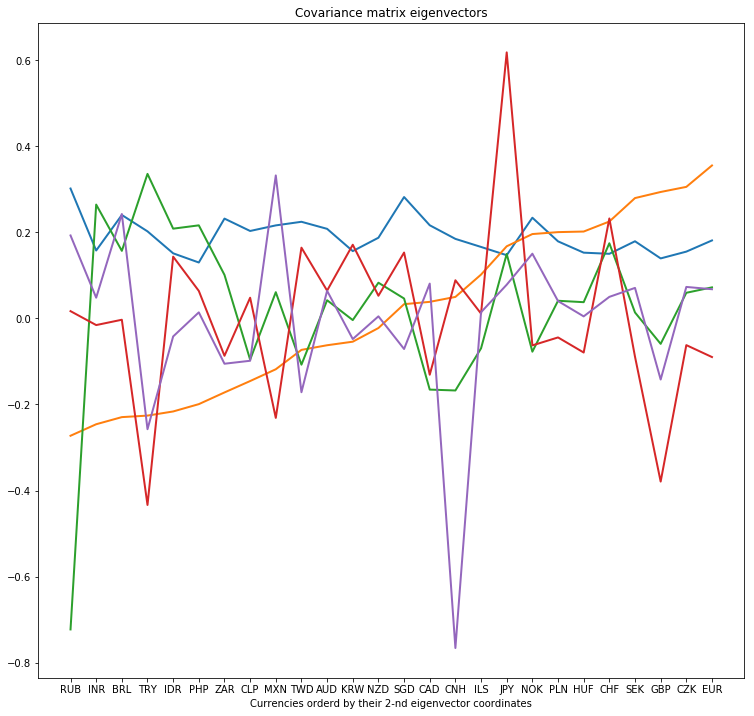

In [5]:
PCALoadings = pd.DataFrame(data=pca.components_,columns=zscores.columns,index=PCAFactors.columns).transpose()
PCALoadings = PCALoadings.sort_values(by='PC2')
plt.figure(0, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(PCALoadings.index,PCALoadings.values, linewidth=2)
plt.xlabel('Currencies orderd by their 2-nd eigenvector coordinates')
plt.title('Covariance matrix eigenvectors')
plt.show()

We are tempted to give an "interpretation" of carry to the 2nd PCA here but be careful. This is a datadriven thing and has no direct connection to the concept of "carry" in FX.

Here, we have a time series of these $px1$ vectors $X_{t} = (X_{t,1}, . . . ,X_{t,p})'$. Let's look at the time series of the principal components that is the sequence of $P_{i,t} = e_{i}'X_{t}$ for each of the 5 components:

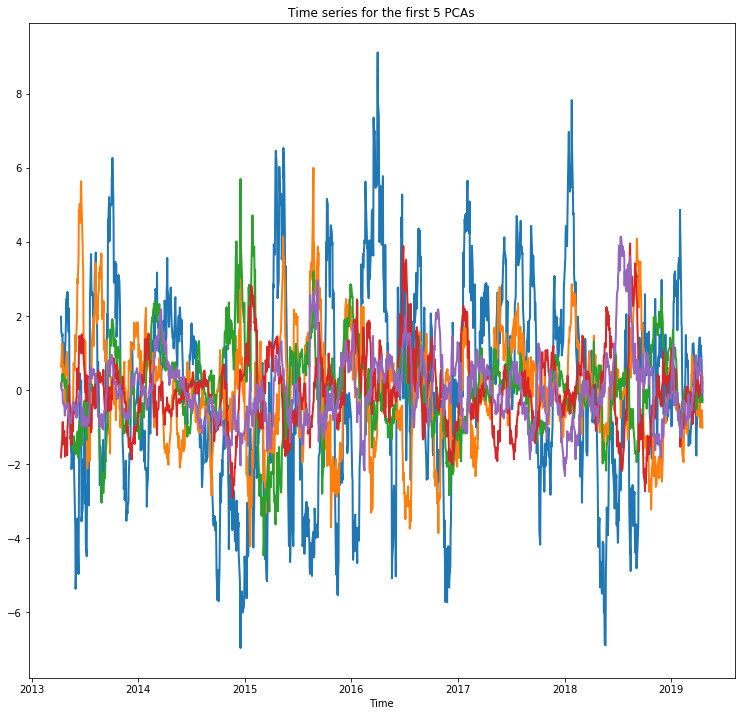

In [6]:
PCALoadings = pd.DataFrame(data=pca.components_,columns=zscores.columns,index=PCAFactors.columns).transpose()
plt.figure(0, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(PCAFactors.index,PCAFactors.values, linewidth=2)
plt.xlabel('Time')
plt.title('Time series for the first %s PCAs' % n_comp)
plt.show()

# PCAFactors.plot(title='Time series for the first %s PCAs' % n_comp)
# plt.show()

# plt.show()

Because these time series are based on the z-scores of the returns, often times we want to plot their cumulative sum to see how they are evolving over time:

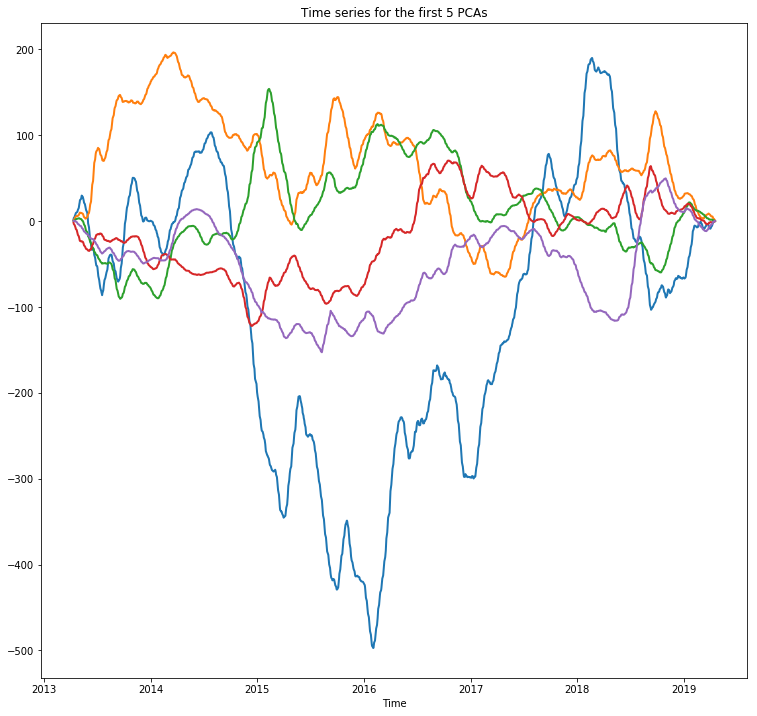

In [7]:
plt.figure(0, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(PCAFactors.index,PCAFactors.cumsum().values, linewidth=2)
plt.xlabel('Time')
plt.title('Time series for the first %s PCAs' % n_comp)
plt.show()

Note that the PCA Factors are uncorrelated with each other (orthogonal) by construction:

In [8]:
print(np.round(PCAFactors.corr(),6))

     PC1  PC2  PC3  PC4  PC5
PC1  1.0  0.0 -0.0 -0.0 -0.0
PC2  0.0  1.0  0.0 -0.0 -0.0
PC3 -0.0  0.0  1.0 -0.0 -0.0
PC4 -0.0 -0.0 -0.0  1.0 -0.0
PC5 -0.0 -0.0 -0.0 -0.0  1.0


Because we know that $\sum_{i=1}^{p} Var(X_{i}) = \sum_{i=1}^{p} \lambda_{i}$. We can think of the magnitude of lambda as how much of the variability of the data can be explained by each principal component. For instance, the proportion of the data variability (as measured by $\Omega$) explained by the i-th PC is given by $\lambda_{k} / \sum_{k=1}^{p} \lambda_{k}$.

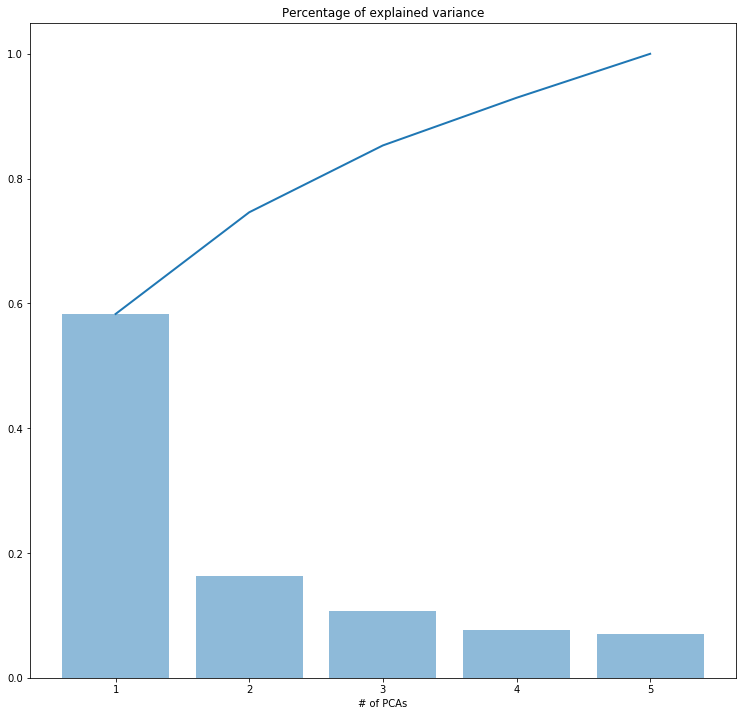

In [9]:
plt.figure(0, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
cumm_explained_variance = [pca.explained_variance_[0]]
for i in range(1,len(pca.explained_variance_)):
    cumm_explained_variance.append(cumm_explained_variance[i-1] + pca.explained_variance_[i])
plt.plot(range(1,len(pca.explained_variance_)+1),cumm_explained_variance/np.sum(pca.explained_variance_), linewidth=2)
plt.bar(range(1,len(pca.explained_variance_)+1), pca.explained_variance_/np.sum(pca.explained_variance_), align='center', alpha=0.5)
plt.xlabel('# of PCAs')
plt.title('Percentage of explained variance')
plt.show()

### Multidimensional scaling

Principal Components Analysis can also be used for classical multidimenstional scalling. Let's use a heatmap to illustrate how some currencies have similarities in terms of correlations:

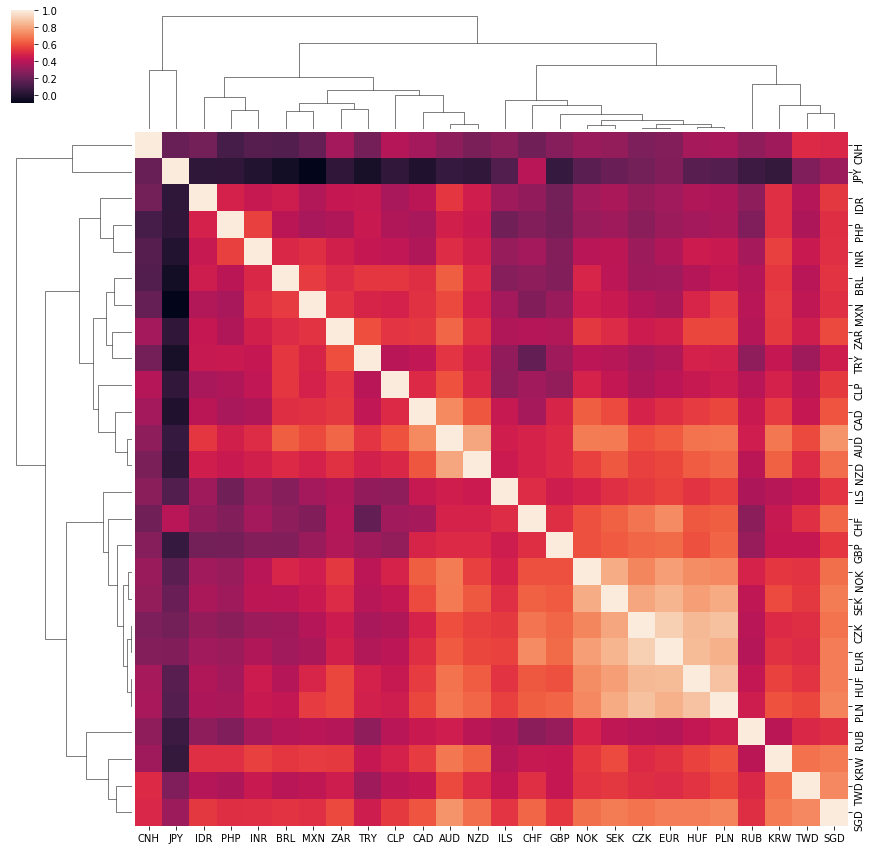

In [10]:
import seaborn as sns
df = returns.corr()
sns.clustermap(df, method='complete',metric='correlation',figsize=(15, 15))

PCA allows us to plot how each currency on the 2-dimenstional space of the first two PCs. Remember, $p_{i,k}$ is the "beta" of currency $k$ to shocks of type $i$, so let's see where each currency is located in the 2-PC senstivity space:

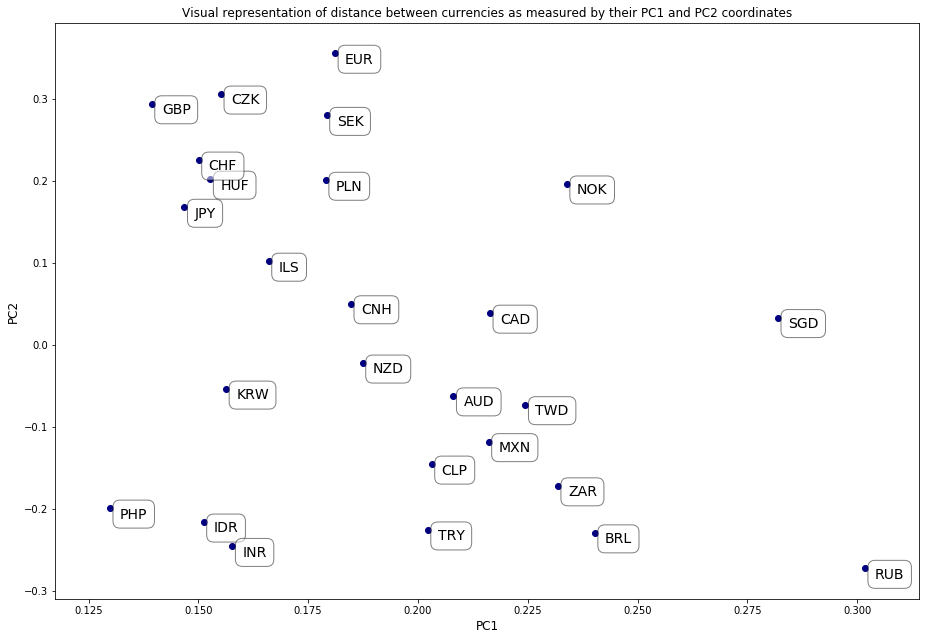

In [11]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 2., 2.])
clf = PCA(n_components=2)
X = pd.DataFrame(data=PCALoadings[['PC1','PC2']].values,columns=['PC1','PC2'],index=PCALoadings.index)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='navy')
plt.title('Visual representation of distance between currencies as measured by their PC1 and PC2 coordinates')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
segments = [[X.iloc[i, :], X.iloc[j, :]] for i in range(len(X)) for j in range(len(X))]

for label, x, y in zip(X.index, X.iloc[:, 0], X.iloc[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=14,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))

plt.show()

It's too bad that we lose the other 3 PCAs when we try to get this visual representation. However, one thing we can do is to measure the distance between two currencies $i$ and $j$ by its five PC coordinates, that is currency $i$ is located at $p_{i,1}, ...,p_{i,k}$ in the PCA space and currency $j$ is located at $p_{j,1}, ...,p_{j,k}$. The distance between these two currencies can be measured by $\|(p_{i,1}, ...,p_{i,k}) - (p_{j,1}, ...,p_{j,k})\|$. We can then draw a line between each $i$ and $j$ and make the line darker if the two currencis are "close" in the 5-PC space:

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


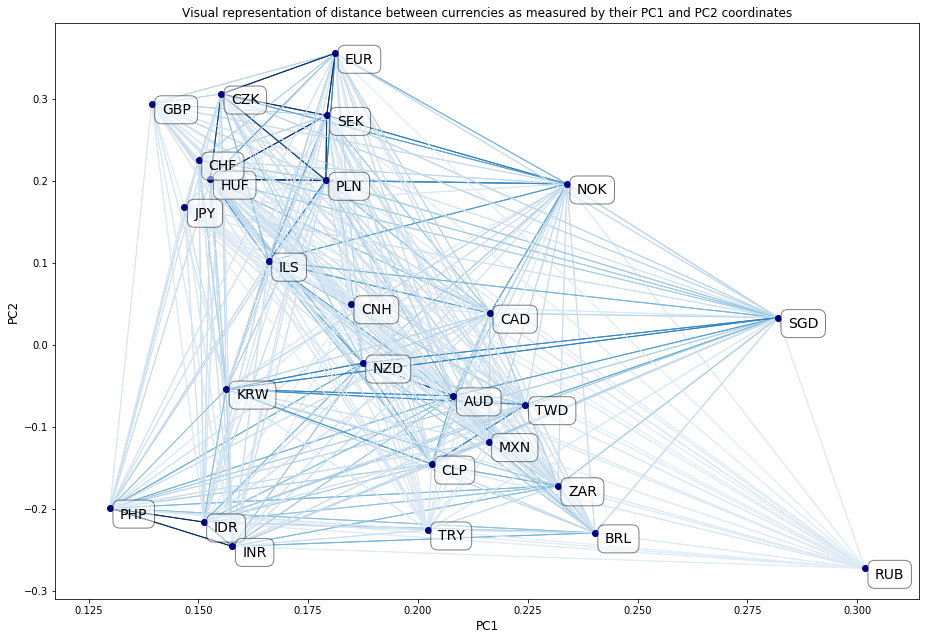

In [12]:
from sklearn.metrics import euclidean_distances
from matplotlib.collections import LineCollection

fig = plt.figure(1)
ax = plt.axes([0., 0., 2., 2.])
similarities = euclidean_distances(PCALoadings.values)
similarities = similarities.max() / similarities*100
similarities[np.isinf(similarities)] = 0
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()/2))

start_idx, end_idx = np.where(X)
fig = plt.figure(1)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='navy')
plt.title('Visual representation of distance between currencies as measured by their PC1 and PC2 coordinates')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
segments = [[X.iloc[i, :], X.iloc[j, :]] for i in range(len(X)) for j in range(len(X))]

for label, x, y in zip(X.index, X.iloc[:, 0], X.iloc[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=14,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
lc.set_array(values.flatten())
# lc.set_linewidths(np.full(len(segments), 1))
lc.set_linewidths(np.ones(len(segments)))
ax.add_collection(lc)
plt.show()

Another way to think about this is to think about the $\Omega$ matrix itself as a type of distance matrix. Say that in correlation space the distance between two currencies $i$ and $j$ is given by $\|(\omega_{i,1}, ...,\omega_{i,p}) - (\omega_{j,1}, ...,\omega_{j,p})\|$. Two currencies that have similar correlation structures to other currencies are "close" to each other. We can then draw a line between each $i$ and $j$ and make the line darker if the two currencis are "close" in the 5-PC space:

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


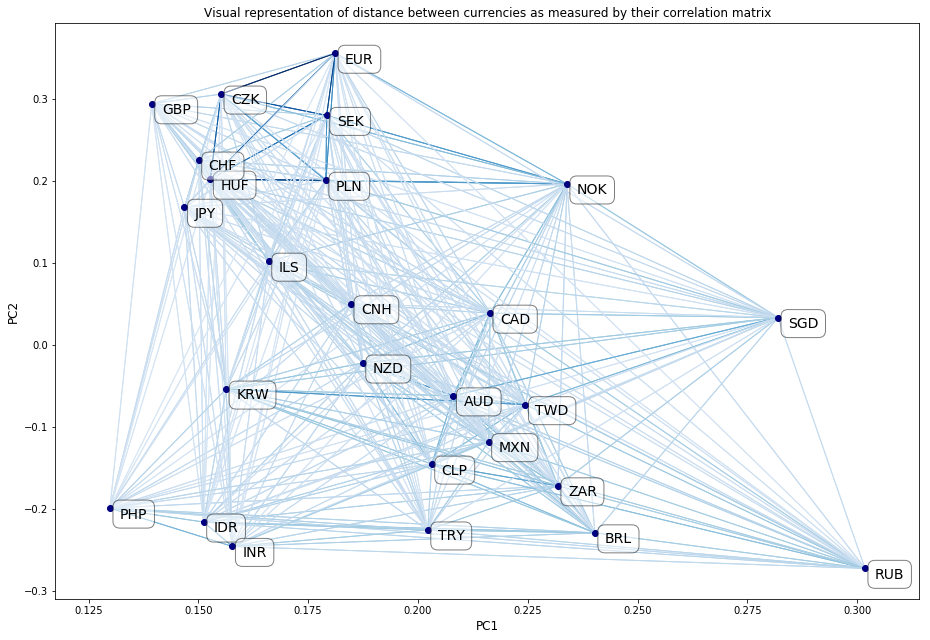

In [13]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 2., 2.])
similarities = euclidean_distances(zscores.corr().values)
similarities = similarities.max() / similarities*100
similarities[np.isinf(similarities)] = 0
values = np.abs(similarities)
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.Blues,
                    norm=plt.Normalize(0, values.max()/2))

start_idx, end_idx = np.where(X)
fig = plt.figure(1)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='navy')
plt.title('Visual representation of distance between currencies as measured by their correlation matrix')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
segments = [[X.iloc[i, :], X.iloc[j, :]] for i in range(len(X)) for j in range(len(X))]

for label, x, y in zip(X.index, X.iloc[:, 0], X.iloc[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=14,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
lc.set_array(values.flatten())
# lc.set_linewidths(np.full(len(segments), 1))
lc.set_linewidths(np.ones(len(segments)))
ax.add_collection(lc)
plt.show()

Visualizing the level of similarity across variables is what Multidimensional scaling (MDS) is about. MDS uses information about the pairwise 'distances' among a set of n objects or individuals into a configuration of n points mapped into an abstract Cartesian space. PCA is one way of carrying that out but there are others. Let's take a look at Metric multidimensional scaling (mMDS) from “Modern Multidimensional Scaling - Theory and Applications” Borg, I.; Groenen P. Springer Series in Statistics (1997):

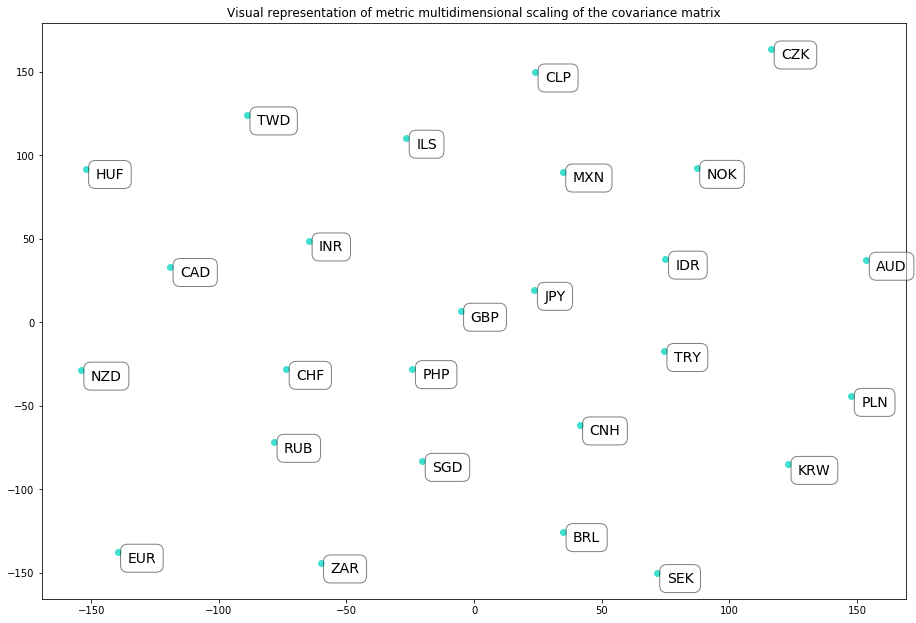

In [14]:
from sklearn import manifold
fig = plt.figure(1)
ax = plt.axes([0., 0., 2., 2.])
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
X = pd.DataFrame(index=zscores.columns,data=mds.fit(similarities).embedding_)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='turquoise')
plt.title('Visual representation of metric multidimensional scaling of the covariance matrix')
segments = [[X.iloc[i, :], X.iloc[j, :]] for i in range(len(X)) for j in range(len(X))]

for label, x, y in zip(X.index, X.iloc[:, 0], X.iloc[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=14,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))

plt.show()

Alternatively, non-metric multidimensional scaling (nMDS) finds both a non-parametric relationship between the dissimilarities in the item-item matrix and the Euclidean distances between items, and the location of each item in the low-dimensional space. So, it's more generic:

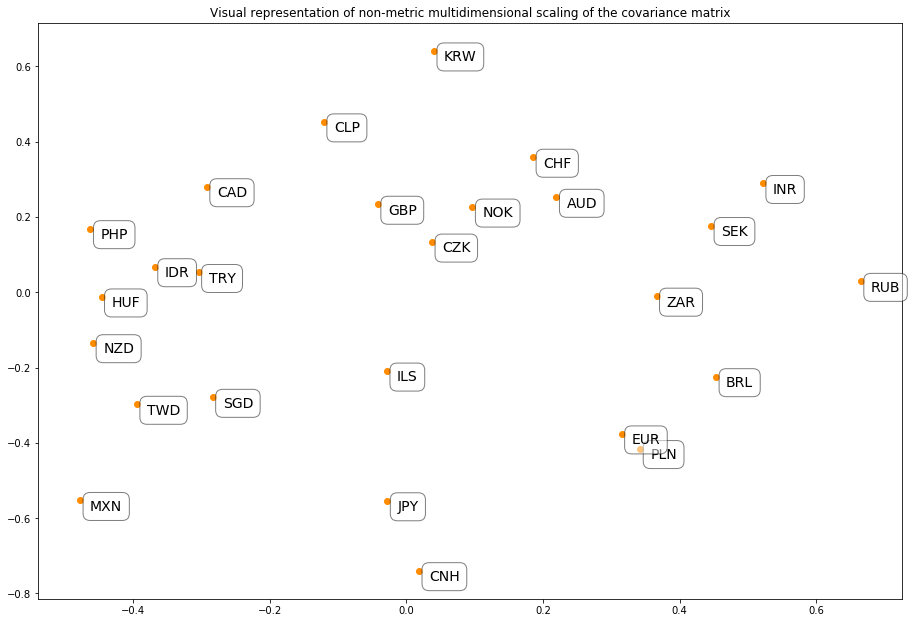

In [15]:
from sklearn import manifold
fig = plt.figure(1)
ax = plt.axes([0., 0., 2., 2.])
seed = np.random.RandomState(seed=3)
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
X = pd.DataFrame(index=zscores.columns,data=nmds.fit(similarities).embedding_)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='darkorange')
plt.title('Visual representation of non-metric multidimensional scaling of the covariance matrix')
segments = [[X.iloc[i, :], X.iloc[j, :]] for i in range(len(X)) for j in range(len(X))]

for label, x, y in zip(X.index, X.iloc[:, 0], X.iloc[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(10, -10), textcoords='offset points',size=14,
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))

plt.show()

### Clustering

One way of measuring how similar two assets are is to measure the distance between the two time series. How? We can think of the time series of normalized returns for asset $i$ as a "vector" $v_{i}$  ${\in}$  $\mathbb{R}^{T}$.

If two assets are very similar to each other assets, it would mean that they would behave more or less in the same way. So, we can think of any distance function that measures the distance between the two vectors $v_{i}$ and $v_{j}$ as a measure of how "different" assets $i$ and $j$ really are.

A classic example of that is the euclidian distance:

$d(v_i, v_j) = \sqrt{(v_{i,1}- v_{j,1})^2 + (v_{i,2}- v_{j,2})^2+\cdots+(v_{i,k}- v_{j,k})^2+\cdots+(v_{i,T}- v_{j,T})^2}$

As we saw before we can see the correlation matrix as a measure of distance between two assets. Each asset has a set of correlations with other assets. For example, each asset $i$ has correlations $\rho_{i,j}$ with each asset $j$ and we can view the correlations $(\rho_{i,1},\ldots,\rho_{i,p})$ as a "vector" $v_{i}$  ${\in}$  $\mathbb{R}^{p}$.

If two assets have very similar correlations with the other assets, it would mean that they would behave more or less in the same way. So, we can think of any distance function that measures the distance between the correlation vectors $v_{i}$ and $v_{j}$ as a measure of how "different" assets $i$ and $j$ really are.

A classic example of that is the euclidian distance:

$d(v_i, v_j) = \sqrt{(v_{i,1}- v_{j,1})^2 + (v_{i,2}- v_{j,2})^2+\cdots+(v_{i,k}- v_{j,k})^2+\cdots+(v_{i,p}- v_{j,p})^2}$

Clustering is simply the process of separating assets in groups that behave alike. We may have a cluster in which assets $i$, $j$, and $k$ are, say $c_{1} = (v_{i},v_{j},v_{k})$, and we can have a cluster in which assets $m$ and $n$ are, say $c_{2} = (v_{m},v_{n})$.

What is the distance between these assets? How far away is cluster $c_1$ from cluster $c_2$?

Here, we use the common notion of "nearest point distance" for the two sets of points. That is, 

$d(c_1, c_2) = min(d(v_i,v_j))$ for all $v_i$ in cluster $c_1$ and all $v_j$ in cluster $c_2$.


This is called the "single-linkage" method for clustering and this distance between two clusters is called the "cophenetic" distance. We will see later taht the cophenetic distance between two objects is the height of the dendrogram where the two branches that include the two objects merge into a single branch.

Ward's minimum variance criterion minimizes the total within-cluster variance. To implement this method, at each step you find the pair of clusters that leads to minimum increase in total within-cluster variance after merging. This increase is a weighted squared distance between cluster centers. At the initial step, all clusters are singletons (clusters containing a single point). To apply a recursive algorithm under this objective function, the initial distance between individual objects must be (proportional to) squared Euclidean distance. The initial cluster distances in Ward's minimum variance method are therefore defined to be the squared Euclidean distance between points.

Note: In software that implements Ward's method, it is important to check whether the function arguments should specify Euclidean distances or squared Euclidean distances.

In [16]:
import scipy.cluster.hierarchy as sch
similarities = np.abs(1-zscores.corr())
Z=sch.linkage(similarities,method='ward')

C:\Users\gsoares\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


### How many clusters should we use?
We want to choose a number of clusters so that adding another cluster does not give much better modeling of the portfolio.

The 3rd columns of the linkage matrix has the distance of the last cluster to its neighboring cluster. When we plot it against the number of clusters, the first clusters will add much information. That is, if we partition in 2 clusters, the clusters are far apart, if we partition in 3, they are less far apart, etc., but at some point the marginal gain will drop, giving an angle in the graph. The "elbow" method chooses the number of clusters is chosen at this point.

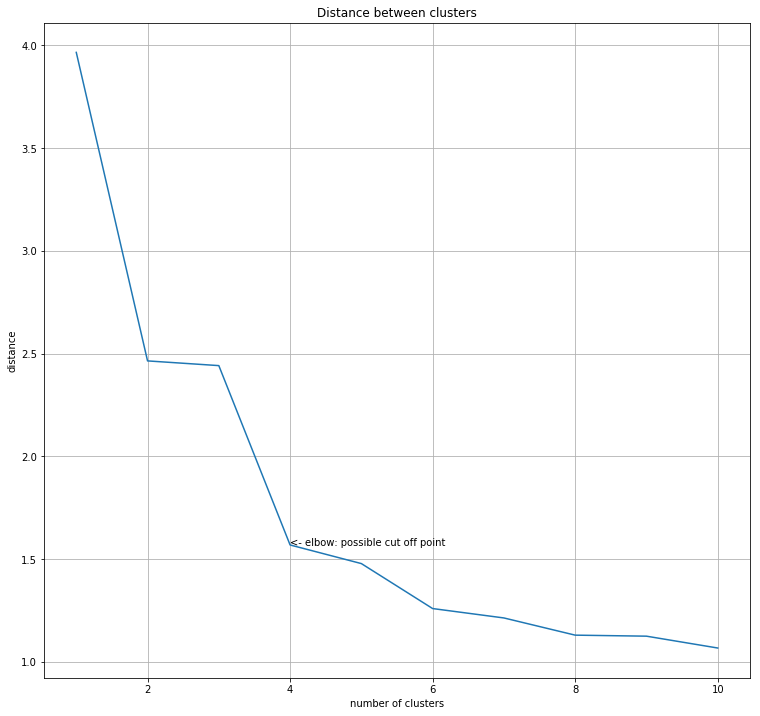

In [17]:
last = Z[-10:, 2] # distance of the additional cluster
last_rev = last[::-1] # revert order
idxs = np.arange(1, len(last) + 1)
knee = np.diff(Z[::-1, 2], 2)
k = 4

plt.figure(0, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(idxs, last_rev)
plt.text(k, Z[::-1, 2][k-1], '<- elbow: possible cut off point')
plt.xlabel('number of clusters')
plt.ylabel('distance')
plt.title('Distance between clusters')
plt.grid(True)
plt.show()

### How to chose the clusters?
Even if we have a method for choosing the number of clusters, we need a method for choosing the assets in each cluster. We use the function sch.fcluster() in order to automate that proces.

Subject to having no more than t clusters formed (where t is a parameter of the function given by you), the function (using the criterion "maxclust") minimizes the the "cophenetic" distance between any two clusters. Note that this is different from simply "clustering by drawing a horizontal line and cutting the dendrogram".

In [18]:
clusters = pd.Series(index=similarities.index,data=sch.fcluster(Z, 5, criterion='maxclust')).sort_values()
for i in sorted(list(set(clusters.values))):
    print('Cluster #%s is:' %str(i))
    for j in clusters[clusters==i].index:
        print(j)
    print('______________________')

Cluster #1 is:
NOK
EUR
CZK
SEK
HUF
PLN
______________________
Cluster #2 is:
JPY
CNH
ILS
CHF
GBP
______________________
Cluster #3 is:
PHP
TRY
INR
IDR
______________________
Cluster #4 is:
CAD
NZD
AUD
SGD
______________________
Cluster #5 is:
ZAR
CLP
RUB
BRL
TWD
KRW
MXN
______________________


It's interesting to see how the currencies get divided in clusters that fit some notion of:

1. European cluster
2. Safe heaven cluster
3. Asian cluster
4. Commodities
5. Other EM cluster

A dendrogram is a diagram representing a tree. In hierarchical clustering, it illustrates the arrangement of the clusters produced by the clustering method.

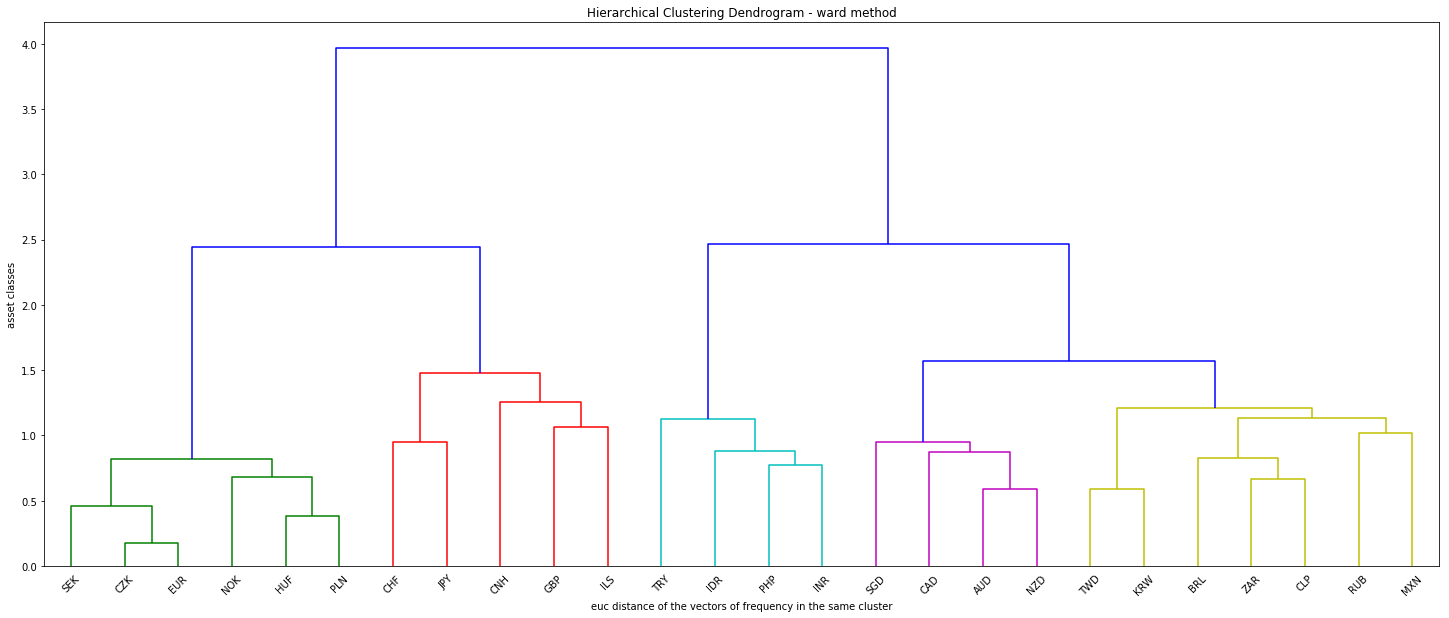

In [19]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram - ward method')
plt.xlabel('euc distance of the vectors of frequency in the same cluster')
plt.ylabel('asset classes')
sch.dendrogram(
    Z,
    labels=zscores.columns,
    orientation='top',
    distance_sort = 'ascending',
    color_threshold=1.5
)
plt.show()

## An appplication of clustering for momentum in FX

Let's start by creating a simple momentum function very similar to the one discussed in JP Morgan's report on trend-following:

In [20]:
from scipy.stats import norm
def get_mom_signals_for_series(index_series, lookback_periods=[21,63,252]):
    normalization_function = lambda x: 2 * norm.cdf(x) - 1
    raw_signals = pd.DataFrame(index=index_series.index, columns=lookback_periods)
    for case in lookback_periods:
        case_returns = index_series.pct_change(case).shift(1)
        case_vols = np.log(index_series).diff(1).rolling(window=case).std().shift(1)
        raw_signals[case] = np.sqrt(252 / case) * case_returns / case_vols
    aggregated_signals = raw_signals.mean(axis=1).apply(normalization_function)
    return aggregated_signals

Based on the signals created by the function above (you should try other types of signals as homework!), we can run backtets for monthly rebalancing rank sorted portfolios as in the "Value and Momentum Everywhere" (2013) paper by Asness, Moskowitz, and Pedersen:

In [21]:
def get_backtest(fx_trackers, signals,chart_title):
    month_ends = signals.resample('M').last().index
    start_date = fx_trackers.loc[:month_ends[0]].index[-1]
    ranks = signals.loc[:start_date].iloc[-1].rank(ascending=False)
    weights = ranks-ranks.mean()
    weights = weights/(np.abs(weights).sum()/2)
    strategy = pd.Series(index=fx_trackers.loc[start_date:].index)
    strategy[start_date] = 100
    p_yst = fx_trackers.loc[start_date]
    holdings = weights*strategy[start_date]/p_yst
    k=1
    for d in strategy.index[1:]:
        p_td = fx_trackers.loc[d]    
        pnl = (holdings*(p_td - p_yst)).sum()
        strategy[d] = strategy[:d].iloc[-2] + pnl
        p_yst = fx_trackers.loc[d]
        if d >= month_ends[k]:
            ranks = signals.loc[:d].iloc[-1].rank(ascending=False)
            weights = ranks-ranks.mean()
            weights = weights/(np.abs(weights).sum()/2)        
            holdings = weights*strategy[d]/p_yst
            k=k+1
    strategy.plot()     
    plt.title(chart_title)
    plt.show()

Let's run the backtest now for all currencies:

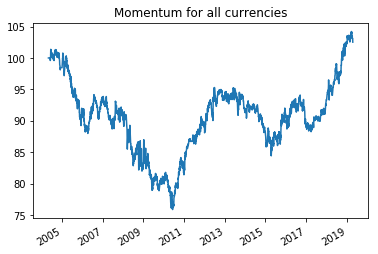

In [22]:
signals = fx_trackers.apply(lambda x : get_mom_signals_for_series(x))
get_backtest(fx_trackers, signals,'Momentum for all currencies')

Ooops ... not that great of a result. Perhaps, if we focus on a smaller set of currencies that cluster together and we try different lookback periods we will find something:

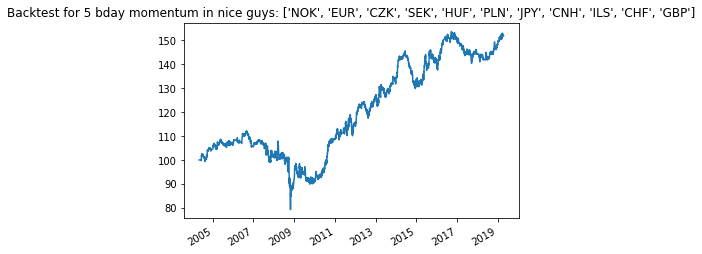

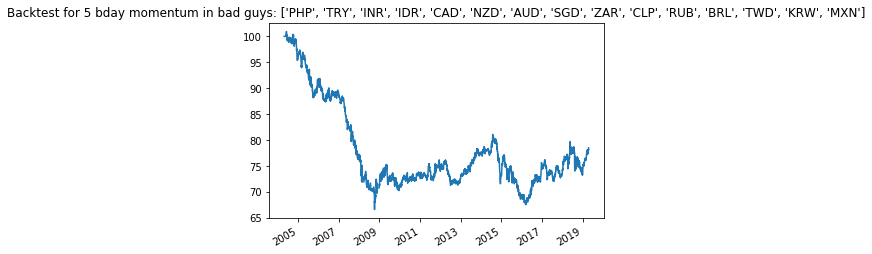

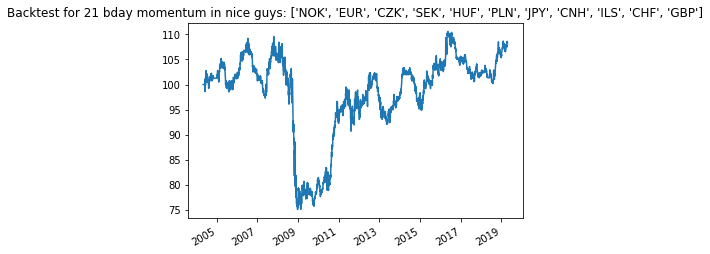

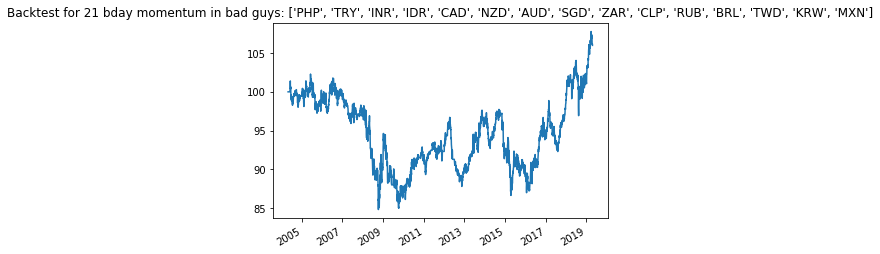

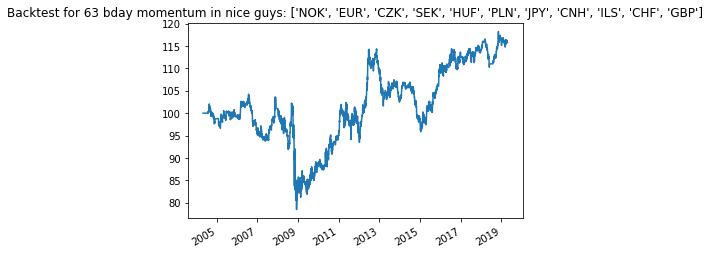

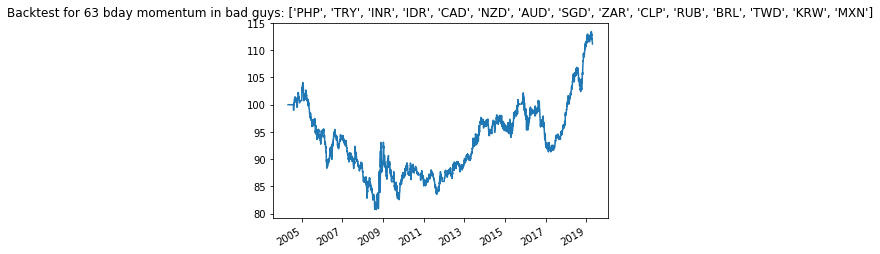

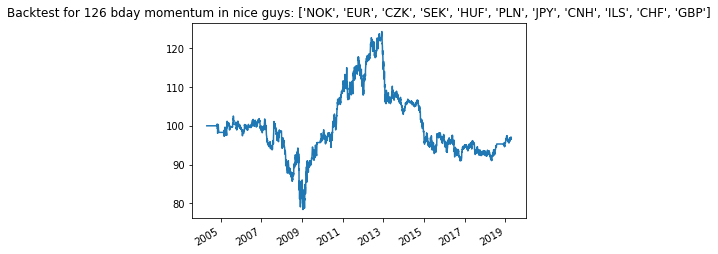

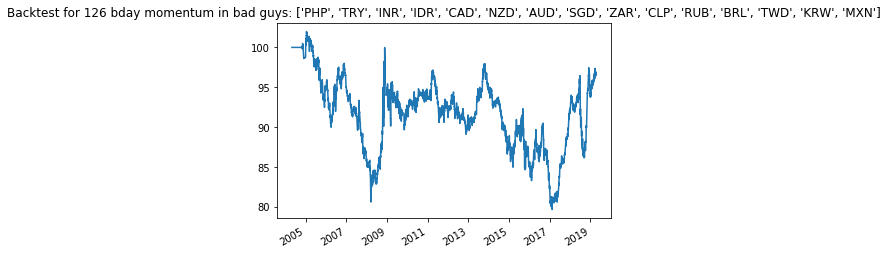

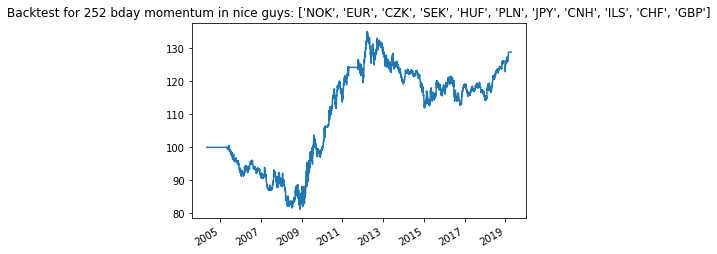

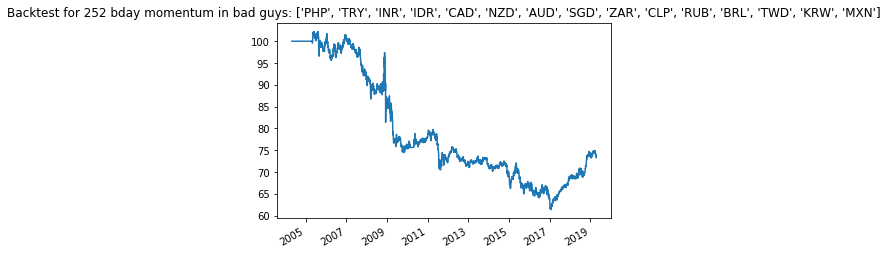

In [23]:
for w in [5,21,63,126,252]:
    signals = fx_trackers.apply(lambda x : get_mom_signals_for_series(x,lookback_periods=[w]))
    nice_guys_cluster = list(clusters[clusters==1].index) + list(clusters[clusters==2].index)
    get_backtest(fx_trackers[nice_guys_cluster],
                 signals[nice_guys_cluster],
                 'Backtest for %s bday momentum in nice guys: %s' % (str(w),nice_guys_cluster))
    bad_guys_cluster = list(clusters[clusters==3].index) + list(clusters[clusters==4].index) + list(clusters[clusters==5].index)
    get_backtest(fx_trackers[bad_guys_cluster],
                 signals[bad_guys_cluster],
                 'Backtest for %s bday momentum in bad guys: %s' % (str(w),bad_guys_cluster))

It seems like momentum is something that works for the nice guys but not the bad guys. Let's aggregate across lookback periods for the nice guys now and see if we get a good momentum strategy:

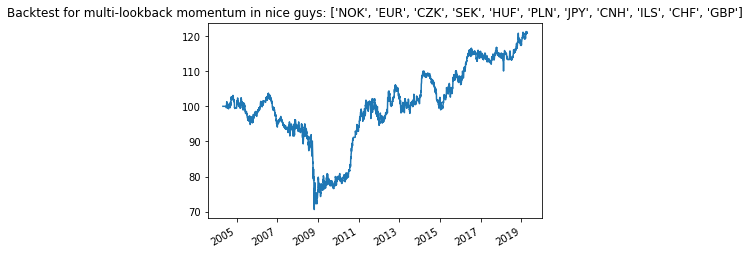

In [30]:
signals = fx_trackers.apply(lambda x : get_mom_signals_for_series(x,lookback_periods=[1,5,10,21,63]))
nice_guys_cluster = list(clusters[clusters==1].index) + list(clusters[clusters==2].index)
get_backtest(fx_trackers[nice_guys_cluster],
             signals[nice_guys_cluster],
             'Backtest for multi-lookback momentum in nice guys: %s' % (nice_guys_cluster))

That's actually not so bad after 2009 but we probably can do a better job if we spend more time on portfolio construction.